# Forecasting GBP (Great Britain Bound) Exchange Rate in relation to Euro

## Notes about Data

In this short project, I will analyze data obtained from the European Central Bank : https://www.ecb.europa.eu/stats/policy_and_exchange_rates/euro_reference_exchange_rates/html/eurofxref-graph-gbp.en.html 

For Copyright information, please see : https://www.ecb.europa.eu/services/using-our-site/disclaimer/html/index.en.html

# Workflow

I will be using the following worflow throughout this notebook

0. Frame the Problem


1. Get the Data

2. Inspect and Clean the Data

<ul>

<li> Data Types </li>
<li> Investigate Missing Dates </li>
 
</ul> 

3. Split the Data

4. Explore the Data

<ul>

<li> Investigate Global Patterns </li>
<li> Investigate weekly seasonality</li>
<li> Investigate yearly seasonality </li>

</ul>


5. Test models

<ul>

<li> ARIMA </li>

</ul>

# 0. Frame the problem 

The aim of this analysis, is to predict the exchange rate of the GBP with respect to the Euro. As such, I will analyze historical data provided by the European Central Bank website. The data analyzed here consists of 6408 exchange rate entries between the 4th of January 1999 and the 9th of January 2025.. New data can be obtained by accessing the .xml file provided on the website, subject to terms and conditions for use of the data.

# 1. Get the Data

Historical data is provided via an xml file. By inspecting the file, we can notice the data is in the "Obs" elements, each such element consisting of several attributes. We are interested in the day of the exchange value  <TIME_PERIOD> and the exchange value itself <OBS_VALUE>. WE can use the namespace to identify the correct tag in the XML file, from which all observation can be extracted via the findall method. Then, it is simply a matter of storing them into a list and converting the list into a dataframe. 

In [1]:
##import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
##parse the document
import xml.etree.ElementTree as ET
tree = ET.parse('/Users/andreibleahu/Documents/Data Science - Personal Projects/ECB Data/GBP_EUR.xml')
root = tree.getroot()

In [3]:

## define the namespace
ns = {'exr': 'http://www.ecb.europa.eu/vocabulary/stats/exr/1'}

# find all observed rates in the namespace
obs_elements = root.findall('.//exr:Obs', ns)

## intialize and empty list to store the data
data = []

## iterate through each observed rate and append the data to the list
for obs in obs_elements:
    date = obs.get('TIME_PERIOD')
    rate = obs.get('OBS_VALUE')
    data.append((date, rate))

## convert the list to a datagrame
gbp = pd.DataFrame(data, columns=['Date', 'Exchange_Rate'])

## convert the 'Date' column to datetime
gbp['Date'] = pd.to_datetime(gbp['Date'])

## convert the 'Exchange_Rate' column to float
gbp['Exchange_Rate'] = gbp['Exchange_Rate'].astype(float)

print(gbp)

           Date  Exchange_Rate
0    1999-01-04        0.71110
1    1999-01-05        0.71220
2    1999-01-06        0.70760
3    1999-01-07        0.70585
4    1999-01-08        0.70940
...         ...            ...
6403 2024-01-03        0.86470
6404 2024-01-04        0.86278
6405 2024-01-05        0.86210
6406 2024-01-08        0.86150
6407 2024-01-09        0.85938

[6408 rows x 2 columns]


In [4]:
gbp

,Date,Exchange_Rate
0,1999-01-04,0.71110
1,1999-01-05,0.71220
2,1999-01-06,0.70760
3,1999-01-07,0.70585
4,1999-01-08,0.70940
...,...,...
6403,2024-01-03,0.86470
6404,2024-01-04,0.86278
6405,2024-01-05,0.86210
6406,2024-01-08,0.86150


# 2. Inspect and Clean the Data

## Data types

Let's quickly look over the data types, check for missing values and make sure all exchange rates make sense.

In [5]:
gbp['Date'].value_counts()  

Date
1999-01-04    1
2015-09-03    1
2015-09-17    1
2015-09-16    1
2015-09-15    1
             ..
2007-05-03    1
2007-05-02    1
2007-04-30    1
2007-04-27    1
2024-01-09    1
Name: count, Length: 6408, dtype: int64

In [6]:
gbp['Exchange_Rate'].describe()

count    6408.000000
mean        0.779123
std         0.099234
min         0.571100
25%         0.682400
50%         0.811300
75%         0.865412
max         0.978550
Name: Exchange_Rate, dtype: float64

In [7]:
gbp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6408 entries, 0 to 6407
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           6408 non-null   datetime64[ns]
 1   Exchange_Rate  6408 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 100.3 KB


Observe:

- the data contains 6408 entries and no nulls (mising values)
- the values are recorded from the 4th of January 1999 to today ( over 25 years of data)
- as of today, 9th of January 2024, the maximum recorded exchange rate is 0.9785 while the minimum exchange rate is 0.5711
- the frequency of the data is daily (new values are recorded on a daily basis, although not necessarily every day by judging from the number of entries and number of days between these years)




This is very clean and easy to understand data. All that is left to do is to make sure it is chronologically ordered by sorting the data by date, after making "Date" the index of the time series. Then, we can check for missing dates, to see on which days during the 1999-2024 period there was no recorded information.

## Investigate Missing Dates


In [8]:
##sort by first entry day and sets the index to be the date column
gbp_sorted = gbp.sort_values(by='Date', ascending=True).set_index('Date') 

In [9]:
##view the first 5 rows of the dataframe
gbp_sorted.head()

,Exchange_Rate
Date,
1999-01-04,0.71110
1999-01-05,0.71220
1999-01-06,0.70760
1999-01-07,0.70585
1999-01-08,0.70940


In [10]:
##view the last 10 rows of the dataframe
gbp_sorted.tail(10)

,Exchange_Rate
Date,
2023-12-22,0.86660
2023-12-27,0.86830
2023-12-28,0.87060
2023-12-29,0.86905
2024-01-02,0.86645
2024-01-03,0.86470
2024-01-04,0.86278
2024-01-05,0.86210
2024-01-08,0.86150


Observe: 

- The frequency is 'daily' but not all days are accounted for. Looking at the last few entries, there is no data for the 6th and 7th of January for example

In [11]:
##create a new date range with the end points of the original dataframe
all_dates = pd.date_range(start=gbp_sorted.index.min(), end=gbp_sorted.index.max())
all_dates

DatetimeIndex(['1999-01-04', '1999-01-05', '1999-01-06', '1999-01-07',
               '1999-01-08', '1999-01-09', '1999-01-10', '1999-01-11',
               '1999-01-12', '1999-01-13',
               ...
               '2023-12-31', '2024-01-01', '2024-01-02', '2024-01-03',
               '2024-01-04', '2024-01-05', '2024-01-06', '2024-01-07',
               '2024-01-08', '2024-01-09'],
              dtype='datetime64[ns]', length=9137, freq='D')

In [12]:
##find all the missing dates
missing_dates = all_dates.difference(gbp_sorted.index)

In [13]:
##look at the dataframe containing the missing dates
missing_dates
print(f"Data is missing on {len(missing_dates)} days")
print(f"Data is missing in the interval {missing_dates.min()} - {missing_dates.max()}")


Data is missing on 2729 days
Data is missing in the interval 1999-01-09 00:00:00 - 2024-01-07 00:00:00


Observe:

- the 6408 observations (rows) are for days between the 4th of January 1999 and the 9th of July 2024. In this interval, we do not have data for 2729 days, which means that we generally information on each day
- this doesn't affect the reliability of our data ( there are no missing values in the current dataframe) but simply puts it in perspective : we now know that GBP exchange rate information for some days

In [14]:
##let's have a look at the missing dates
missing_dates

DatetimeIndex(['1999-01-09', '1999-01-10', '1999-01-16', '1999-01-17',
               '1999-01-23', '1999-01-24', '1999-01-30', '1999-01-31',
               '1999-02-06', '1999-02-07',
               ...
               '2023-12-17', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-30', '2023-12-31', '2024-01-01',
               '2024-01-06', '2024-01-07'],
              dtype='datetime64[ns]', length=2729, freq=None)

In [15]:
##create a new dataframe with all the dates and mark them as 0
all_dates_encoded = pd.DataFrame(0, index=all_dates, columns=['Exchange_Rate']) 
##set the values of the dates that are present in the original dataframe to 1
all_dates_encoded.loc[gbp_sorted.index] = 1
##let's do a sanity check to understand if all days are accounted for
all_dates_encoded['Exchange_Rate'].value_counts()

Exchange_Rate
1    6408
0    2729
Name: count, dtype: int64

In the above, I created a dataframe that marks clearly if the exchnage rate is present for every day between 1999-01-04 and 2024-01-09. If there is data on the exchange value on that day, the entry contains 1 and if it's missing is 0. Hence, the frequency of available data has been one-hot encoded. Now, if we plot the values in the dataframe above, we can clearly see if there is a pattern in missing values.

In [16]:
##calculate frequency of days with no information in the interval
noinfo_frequency = all_dates_encoded['Exchange_Rate'].value_counts()[0] / len(all_dates_encoded)
print(f"Frequency of days with no information: {noinfo_frequency:.2%}")

Frequency of days with no information: 29.87%


In [17]:
all_dates_encoded.head()

,Exchange_Rate
1999-01-04,1
1999-01-05,1
1999-01-06,1
1999-01-07,1
1999-01-08,1


Approximately 1 if 3 days offers no information on the exchange rate. It is also important to understand if the 0's (days with no information) are randomly distributed.

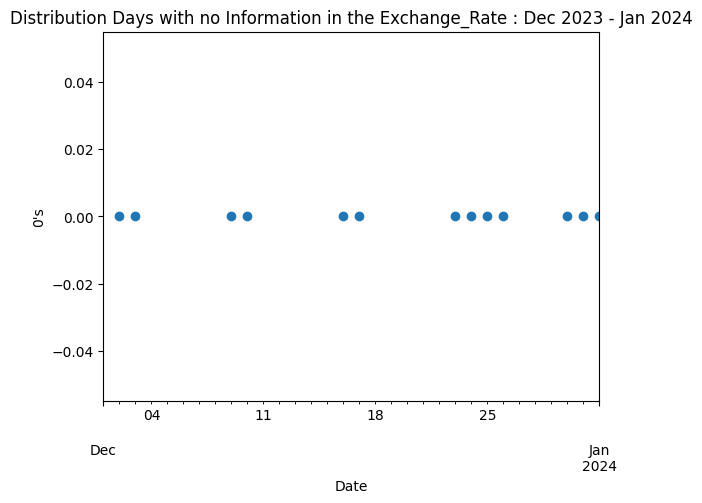

In [18]:
#let's creae a dataframe with the 0's and 1's are replaced with NaN
df_zeros = all_dates_encoded['Exchange_Rate'].replace(1, np.nan)

#as there are many values, let us select a small interval visualize
df_zeros.loc['2023-12-01': '2024-01-01'].plot(style='o')
plt.title("Distribution Days with no Information in the Exchange_Rate : Dec 2023 - Jan 2024")
plt.xlabel("Date")
plt.ylabel("0's")
plt.show()

Observe:

- The blue dots represent days in December 2023 where no values were recorded and it looks that all these days are holidays or weekends
- the 2nd and 3rd of December 2023 fell on a weekend (and no info is marked)
- Hence, the frequency of missing days is most likely connected to data not being recorded on weekends and holidays.

Let's also look at a different month, to get an idea of which days have no information recorded

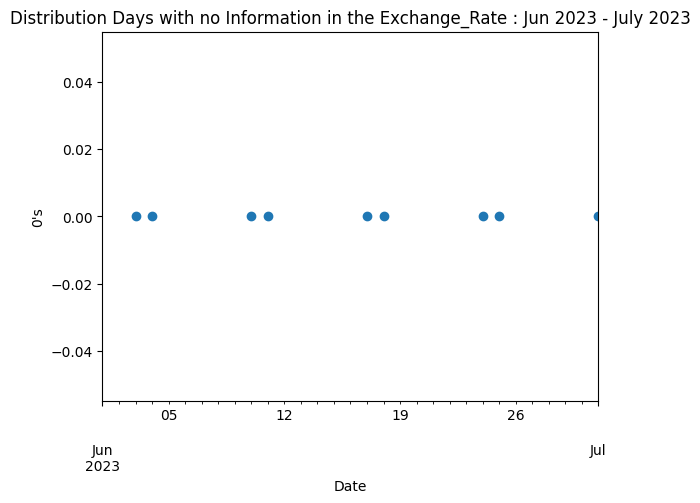

In [19]:
#let's creae a dataframe with the 0's and 1's are replaced with NaN
df_zeros = all_dates_encoded['Exchange_Rate'].replace(1, np.nan)

#as there are many values, let us select a small interval visualize
df_zeros.loc['2023-06-01': '2023-07-01'].plot(style='o')
plt.title("Distribution Days with no Information in the Exchange_Rate : Jun 2023 - July 2023")
plt.xlabel("Date")
plt.ylabel("0's")
plt.show()

Observe :

- Clearly, there is no data on weekends

In [20]:
##let's compare the frequency of weekend time with the value we found
weekend_frequency = 2/7 * 100 ## 2 days out of 7 are weekend days (on average)
print(f"Frequency of weekend days: {weekend_frequency:.2f}%")
print(f"Frequency of days with no information: {noinfo_frequency:.2%}")

Frequency of weekend days: 28.57%
Frequency of days with no information: 29.87%


Judging by this similarity of scores and by the patterns above, it is clear that no data has been recorded on weekends and public holidays. Hence:

- We have exchange rate GBP to EUR data for all days save weekends and public holidays between 1999-01-04 and 2024-01-09
- The data is very clean and there is no apparent reason to doubt it

Before further exploring the data let us split it into a test and training set. The test set will be used later for internal validation, so it is best not to look at it during EDA( we treat it as unknown data)

# 3. Split the Data

There are two steps in determining how good the models are. First, I will internally validate the model on some test data taken from my data, use an evaluation metric (MAPE in this case) to measure its performance and then test it on real world data to externally validate it

In [21]:
##create test set as the last 3 months of the data
test = gbp_sorted.loc['2023-10-01':]

##create train set as the rest of the data
train = gbp_sorted.loc[:'2023-09-30']

In [22]:
##create a copy of the train set for further exploration
explore = train.copy()

# 4. Explore the Data

## Investigate Seasonality

In the first step, I will investigate the data to see if there is any obvious periodicity. This is because, a time series can be _naively forecasted_ if it changes according to a very obvious relationship. For example, sinusoidal data can very easily be considered periodic, with the maxima and minima being exactly the same at a specific time period called the period T. If a periodic pattern holds,  naive forecasting can be employed by exploiting such periodicities, given a time signal x that is periodic with period T :

$$ x(t) = x(t+T)$$



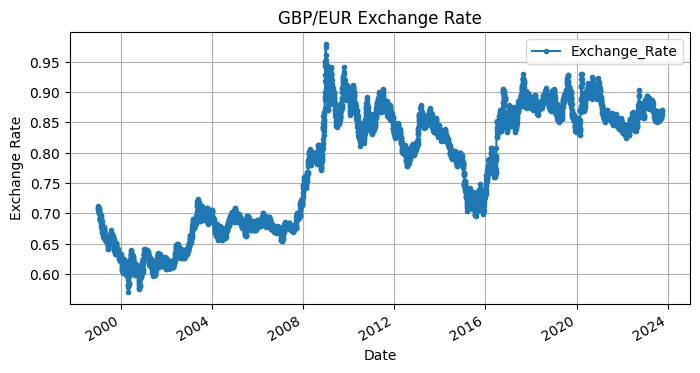

In [23]:
explore.plot(grid=True, marker=".", figsize=(8,4))
plt.title("GBP/EUR Exchange Rate")
plt.ylabel("Exchange Rate")
plt.xlabel("Date")
plt.show()

Observe :

- This is a _Univariate time series_ with a single value looked over a series of time
- At first glance it seems the pound value or devalues given specific periods spanning several years, however no specific periodic pattern emerges
- We see an increase of the exchange rate ( remember that a greater exchange rate means the pound is devaluing with respect to the EUR) in the years after the 'Brexit' vote
- The pounds seems to be weaker in 2009 (almost equal to the EUR)
- The strongest pount is seen during the early 2000's (with the EURO being a new currency)
- The pound is stronger now than in 2009, but very weak compared to early 2000's

Notes: 

- the smaller the exchange rate, the stronger is the pound in relation to the EUR. For example, an exchange value of 0.7 of GBP to EUR mean that 1 EUR can purchase 70p or 0.7 of 1GDP thus making the pound stronger
- any prediction of GBP must take into account external events ( the outcome of the 'Brexit' vote may have had has an impact on the value of the pound with respect to the EUR )

In the following, I will investigate if there is (i) weekly or monthly seasonality or (ii) yearly seasonality. This is because sometimes there is a strong weekly, monthly or yearly pattern that allows good predictions. Clearly, for weekly seasonality, it makes sense to investigate a more recent slice of the data, for example 2022-2024. This is for two reasons : (a) the data is steady with respect to the 25-year period and (b) to predict the exchange rate in the following weeks, it makes sense to analyze recent weeks as they are part of the same time period.

## Investigate Weekly Seasonality

To make accurate predictions, let us focus on a slice of the data that represents a relatively recent (and stable!) segment. It is clear that the 2022-2024 does not present very strong oscillations as the value of the data is contained within the range 0.85 - 0.9. Let's first select this slice of data

In [24]:
##select slice of data from 2022 onwards
df_2022onwards = explore.loc['2022-01-01':]

In [25]:
df_2022onwards

,Exchange_Rate
Date,
2022-01-03,0.84135
2022-01-04,0.83618
2022-01-05,0.83546
2022-01-06,0.83593
2022-01-07,0.83430
...,...
2023-09-25,0.86965
2023-09-26,0.87020
2023-09-27,0.86810


In [26]:
df_2022onwards.describe()

,Exchange_Rate
count,449.000000
mean,0.860440
std,0.016809
min,0.823880
25%,0.846700
50%,0.859900
75%,0.873950
max,0.902680


In [27]:
len(df_2022onwards)

449

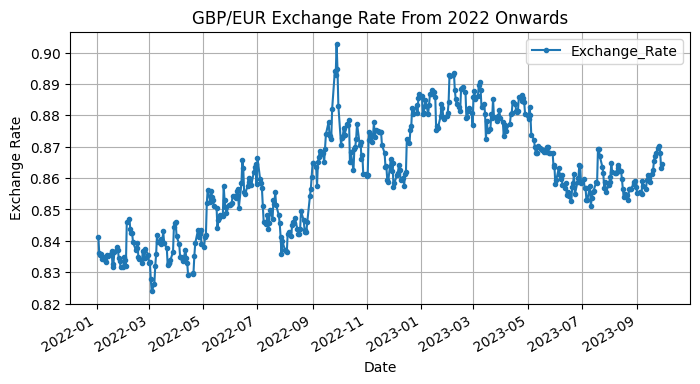

In [28]:
##visualize the data from 2022 onwards
df_2022onwards.plot(grid=True, marker=".", figsize=(8,4))
plt.title("GBP/EUR Exchange Rate From 2022 Onwards")
plt.ylabel("Exchange Rate")
plt.xlabel("Date")
plt.show()


Observe:

- The signal varies between 0.82 and approximately 0.9, with lower exchange values signifiyng a stronger pound
- the pound has been weakest in October 2022 and strongest in January 2022, with 2023 showing overall weakening of the pound

Given the above, it is better to understand how the time series changes over the course of a week. To do this, I will plot the lagged series with 7 days ( a week) and compare (i) the original series, (ii) the lagged time series and (iii) the difference between (i) and (ii). The difference between the values of the time series over 7 days is called _differencing_. 

In [29]:
##this is the diffenced time series 
diff_week = df_2022onwards.diff(7)

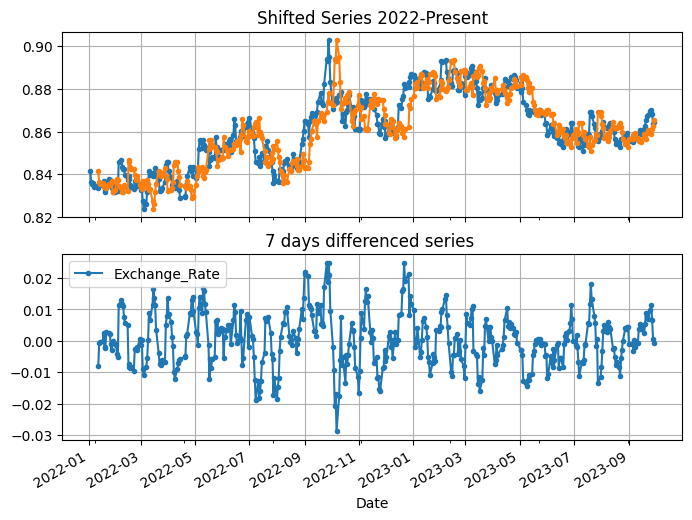

In [30]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 6)) ##Sharex ensures the plot share the same x axis
df_2022onwards.plot(ax=axs[0], grid=True, marker=".", legend=False,  title="Shifted Series 2022-Present") ##plot the original data
df_2022onwards.shift(7).plot(ax=axs[0], grid=True, marker=".", legend=False) ##plot the data shifted by 7 days (one week)
diff_week.plot(ax=axs[1], grid=True, marker=".", title="7 days differenced series ") ##plot the differenced data
plt.show()

Observe :

- The top plot presents the values shifted by one week, while the bottom plot shows how much the exchange rate changed over one week, that is, the evolution of its rate of change when said rate of change is measured as the difference between GBP exchange rates over a week
- The biggest exchange rate happens when the pound is at it's lowest value corresponding to highest exchange rate (0.9 exchange rate in October 2022 represents lowest value) 
- The lagged series (orange) doesn't seem to follow the orginal series (blue) closely : values change from week to week
- The strong oscillations in the differenced series show that there isn't much weekly seasonality
- Most differences are in the range -0.02 to 0.02 with the biggest difference at the beggining of October 2022 (around 0.05 fluctuation). 
- The rate of change (the bottom plot) shows that is is mostly oscillating around a constant value of 0, with fluctuations between -0.03 ( exchange rate is lower than previous week) to  0.02 exchange rate is higher. There is no obvious ascending or descending trend over this period.
- Hence, the pound's value is generally changing, but the _rate of change_ (how fast it changes) indicates a rather steady value for the pound around 0.86 with a variation of 0.04. This result is consistent with the increase of 0.86 (Jan 2024) from 0.84 at the beggining of 2022 - the oscillations in the differenced series show how the pound changes over a week, for each week

In [31]:
##calculate the autocorrelation of the differenced series
acf_7 = df_2022onwards['Exchange_Rate'].autocorr(lag=7)  

In [32]:
print("Autocorrelation coefficient for 7 days lag is:", acf_7) 

Autocorrelation coefficient for 7 days lag is: 0.8767739209051181


Notes:

- We obtained an auto-correlation coefficient of 87%, which indicates a strong positive correlation between the time series with a one-week lagged version of itself. 
- This suggests that high values of the pound in the previous week may be used to predict high values of the pound during the current week. 
- Hence, the past week is a pretty good predictor of the future (87%)  

To obtain a better understanding of the time series, I will look at it's behaviour for 2023



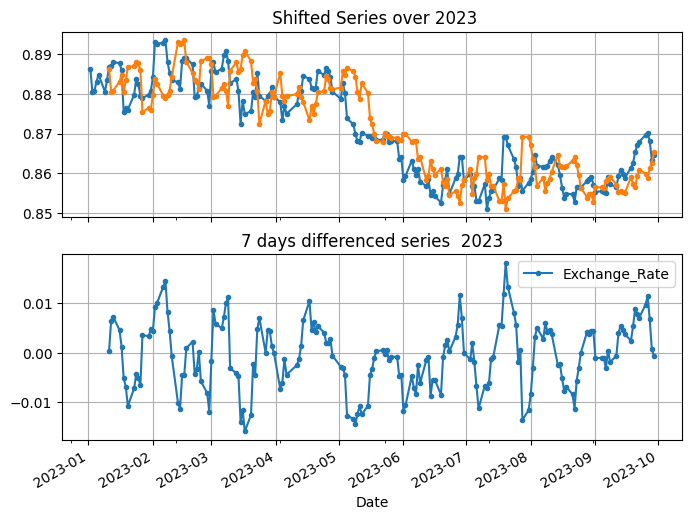

In [33]:
df_2023 = df_2022onwards.loc['2023-01-01':]
diff_dec_week = df_2023.diff(7)
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 6)) ##Sharex ensures the plot share the same x axis
df_2023.plot(ax=axs[0], grid=True, marker=".", legend=False,  title=" Shifted Series over 2023") ##plot the original data
df_2023.shift(7).plot(ax=axs[0], grid=True, marker=".", legend=False) ##plot the data shifted by 7 days (one week)
diff_dec_week.plot(ax=axs[1], grid=True, marker=".", title="7 days differenced series  2023") ##plot the differenced data    
plt.show()

Observe: 


- As shown by the auto-correlation coefficient, past-weekly trends are good predictors of whether the pound will be going up or down, but they _cannot be used to predict the value with high accuracy_
- The weekly trends do not capture the larger trends for Jan - April 2023 (descending), followed by stabilisation around 0.85

Let's calculate the Mean Absolute Error (MAE) and mean absolute percentage error  (MAPE) to understand how strpng is the weekly seasonality 

In [34]:
##calculate mean absolute error of the differenced series
mae_dec = diff_dec_week.abs().mean()
print("Mean absolute error for Oct-Dec 2023 is:", mae_dec)
##let's get the target values 
targets = df_2023[['Exchange_Rate']]
##calculate the mean absolute percentage error
mape_dec = (diff_dec_week/targets).abs().mean()
print("Mean absolute percentage error for Oct-Dec 2023 is:", mape_dec*100, "%")

Mean absolute error for Oct-Dec 2023 is: Exchange_Rate    0.005392
dtype: float64
Mean absolute percentage error for Oct-Dec 2023 is: Exchange_Rate    0.619144
dtype: float64 %


Let's plot an auto-correlation graph that shows how this function varies when the lag is changed.

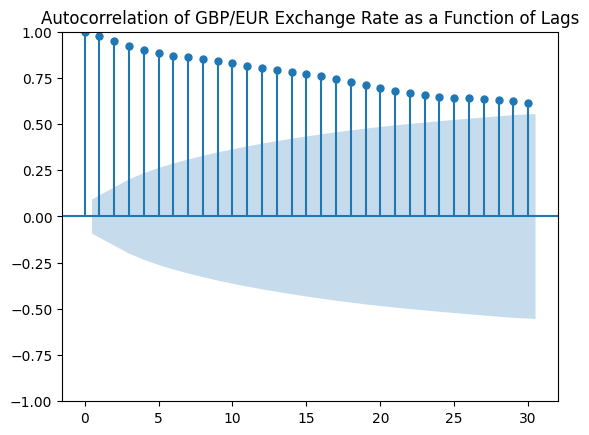

In [35]:
from statsmodels.graphics.tsaplots import plot_acf

##plot the autocorrelation for data starting from 2022 onwards
## the function is calculated for 10 lags (time series incrementally shifted by 1 to 30 days)
plot_acf(df_2022onwards['Exchange_Rate'], lags=30, title="Autocorrelation of GBP/EUR Exchange Rate as a Function of Lags")
plt.show()


Observation on Naive Forecasting:

- Highest auto-correlation is 100% and it is of the series with itself (this is completely expected as any object is identical with itself)
- Around 7 days we can see the value of the auto-correlation function is our calculated value, but not clearly visible on this scale
- Naive Forecasting (taking the value of one week ago as the correct value) gives us a MAPE of 0.62%, which given the stability of the pound over several months is not a ver accurate prediction

## Investigate Yearly Seasonality 

To investigate yearly seasonality, I will look at data until 2019, to avoid drawing conclusions from very recent data. The purpose of this analysis is to reveal if there are any _long term_ trends that should be considered. To do this, I will plot the rolling average of the series.

In [36]:
##create a resampled dataframe with the mean exchange rate for monthly periods
period = slice('2001', '2019')
df_monthly = gbp_sorted.resample('M').mean()

In [37]:
##calculate the rolling average for 12 months
rolling_avg = df_monthly['2000': '2019'].rolling(12).mean()

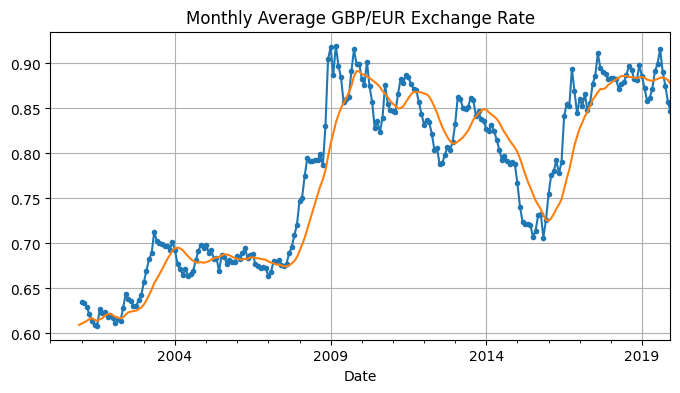

In [38]:
##plot the rolling average and the mean for each month
fig, ax = plt.subplots(figsize=(8,4))
df_monthly[period].plot(ax=ax, grid=True, marker=".", legend=False, title="Monthly Average GBP/EUR Exchange Rate")
rolling_avg.plot(ax=ax, grid=True, legend=False)
plt.show()


Observe:

- I plotted a rolling average of 12 months (one year) against data representing the mean of the exchange rates
- It is quite clear that there is some yearly trends : 2001-2004, 2008-2010 and 2016-2018 show periods of increased exchange rates(on average) : roughly every 7-8 years the average yearly exchange rate has gone up, tipically for 2-3 years before levelling and going down

Before proceeding to modelling the problem, I will plot the 12-month differenced series to see how steady it is


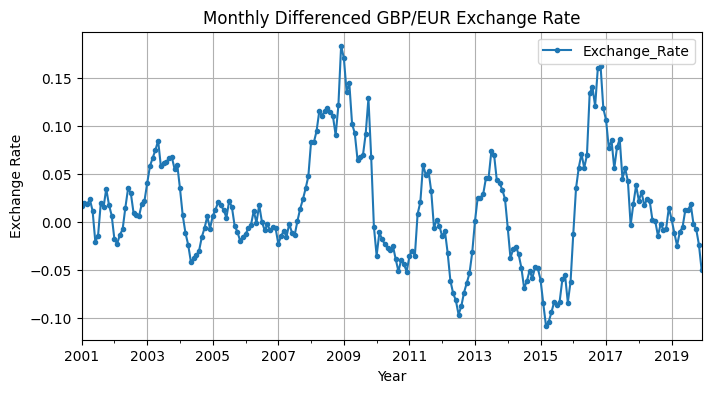

In [39]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8,4))
plt.title("Monthly Differenced GBP/EUR Exchange Rate")
plt.ylabel("Exchange Rate")
plt.xlabel("Year")
plt.show()

Observe:

- The yearly seasonality observed before has mostly reduced
- Differencing can be a useful tool in removing trend and seasonality
- But the above differenced series actually supports the trends identified above (compare 2009 and 2017 values, which indicate that the pound changed the same during these peridos )

Next, I will continue by preparing data machine learning models while incorporating the insights gained from the exploratory data analysis. 

# 5. Test Models

## ARIMA

First, I will explore several ARMA models to see how succesful are they in predicting the time series. ARMA uses an auto-regressive model that computes a weighted sum of past values to which it adds a sum of forecast errors (the moving average component). The model applies subsequent differencing to the data, making it stationary and then extracting predictions. I will use ARIMA as this generally considers weekly seasonality

In [40]:
##import ARIMA model
from statsmodels.tsa.arima.model import ARIMA

Let's try to train it on all available data, despite the various changes across the years

In [41]:
##build the model
model = ARIMA(train, 
              order=(1,1,1), ##p,d,q
              seasonal_order=(1,1,1,12)) ##P,D,Q,m (m is the number of periods in each season)
##fit the model
model = model.fit()


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Observe : 

- the warning comes from not specifying the daily frequency "D", as the data will have probably introduced NaN's corresponding to the weekend's and public holidays

Let's see what the model predicts for "tomorrow" the 10th of January

In [43]:
tom_pred = model.forecast() 


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [44]:
tom_pred    

6339    0.864471
dtype: float64

The model predicted 0.864471 for the 10th of January, while the actual value as seen on the ECB website is 0.86023

In [45]:
real_tom_value = 0.86023

In [46]:
##calculate the mean absolute percentage error
mape_tom_arima = np.abs((tom_pred - real_tom_value)/real_tom_value)
mape_tom_arima
print ("MAPE for 10th of Jan 2024 prediction is:", mape_tom_arima*100, "%")

MAPE for 10th of Jan 2024 prediction is: 6339    0.492957
dtype: float64 %


Observe:

- This forecast is better than using naive forecasting. Recall that $MAPE_{naive} = 0.61\% $ which is a lot greater than $ MAPE_{arima} = 0.4929\%$
- Hence arima provides very accurate predictions compared to naive forecasting 
- Recall that we trained it on all data, rather than on a more stable period such as 2023

We only forecasted the next time step (1 day). Let us forecast the exchange rates until the end of the month

In [47]:
##let's give the date ranges for the predictions ( in this example they start from the 10th of January 2024)    
pred_start = "2024-01-10"

In [48]:
##the step parameter is used to specify the number of steps ahead to forecast
##modify the step to get the desired number of predictions
end_Jan_predictions = model.forecast(steps=20)

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [49]:
##replace the index of the predictions with the date range
##modify the periods to match the number of predictions
end_Jan_predictions.index = pd.date_range(start=pred_start, periods=20)

In [50]:
end_Jan_predictions

2024-01-10    0.864471
2024-01-11    0.864492
2024-01-12    0.864572
2024-01-13    0.864542
2024-01-14    0.864398
2024-01-15    0.864398
2024-01-16    0.864370
2024-01-17    0.864810
2024-01-18    0.864629
2024-01-19    0.864586
2024-01-20    0.864932
2024-01-21    0.864858
2024-01-22    0.864675
2024-01-23    0.864720
2024-01-24    0.864794
2024-01-25    0.864767
2024-01-26    0.864625
2024-01-27    0.864626
2024-01-28    0.864599
2024-01-29    0.865040
Freq: D, Name: predicted_mean, dtype: float64